### Introduction

The goal of this analysis is to evaluate M+ class balance in Blizzard Activision's MMORPG World of Warcraft. "M+" is a small-group mode of gameplay, where a group of 5 players take on a gameplay challenge that must be completed within an alloted timelimit of 30-40 minutes (depending on specific challenge). As players complete a challenge, their get access of an exponentially more difficult (1.08x) version of it, and their progress is reflected on a publically-viewable community leaderboards.

This mode of gameplay naturally lends itself to a competitive milieu, with top players constantly optimizing their strategies and team compositions in order to beat more challenges and achieve a higher score.

The goal of this notebook is to view how player approach to team compositions has changed over the last 3 years. Ideally, learning from the past 3 years could let us predict what players how players are going to behave in the future, or whether that is at all possible.

We did this XYZ, and we found that predicting the metagame is relatively stable, whilst being very unstable, in other positions. We found that the 

### Thing I want to learn
-Change in tank class representation over time<br>
-Change in healer class representation<br>
-Change in dps class representation (melee/range)<br>
-Shift between melee-heavy and range-heavy compositions<br>
-Most represented affixes (season by season, and overall)<br>
-Most represented team compositions<br>

In [429]:
import requests
import pandas as pd
import time
import pickle
from collections import OrderedDict
import matplotlib.pyplot as plt

import numpy as np


pd.options.display.max_columns = 100

### Access the data
First, we need to scrape data from raider.io, which provides an API to access the top 100 m+ runs for each dungeon/season.

In [430]:
#raider.io slugs for m+ dungeons and seasons
legion_dungeons = ['black-rook-hold', 'cathedral-of-eternal-night',
                   'court-of-stars','darkheart-thicket', 'eye-of-azshara', 
                   'halls-of-valor', 'maw-of-souls', 'neltharions-lair',
                   'return-to-karazhan-lower', 'return-to-karazhan-upper', 
                   'seat-of-the-triumvirate', 'the-arcway',
                   'vault-of-the-wardens']

legion_seasons = ['season-7.2.0', 'season-7.2.5', 'season-7.3.0',
                  'season-7.3.2', 'season-post-legion', 'season-pre-bfa']

bfa_dungeons = ['ataldazar', 'freehold', 'kings-rest',
                'operation-mechagon-junkyard', 'operation-mechagon-workshop',
                'shrine-of-the-storm', 'siege-of-boralus',
                'temple-of-sethraliss', 'the-motherlode', 'the-underrot',
                'tol-dagor','waycrest-manor']

bfa_seasons = ['season-bfa-1', 'season-bfa-2', 'season-bfa-3',
               'season-bfa-3-post', 'season-bfa-4']

regions = ['us', 'eu', 'kr', 'tw']

In [431]:
class RioScraper:
    '''
    Wrapper to generate API calls to raider.io
    See raider.io API documentation at https://raider.io/api#/
    
    Attributes
    ----------
    expansion : str
        string denoting the game expansion
    dungeons : list
        list of dungeons string tokens for raider.io API
    seasons : list
        list of season string tokens for raider.io API
    regions : list
        list of region string tokens
    urls : list of strs
        list of url calls covering combinations of attributes above
        (dungeon * season * region)
    raw_data : list
        list of responses generated by the url calls to raider.io
    '''
    
    def __init__(self, expansion, dungeons, seasons, regions):
        '''
        Initializes scraper with tokens to be queried
        
        Parameters
        ----------
        expansion : str
            string denoting the game expansion
        dungeons : list
            list of dungeons tokens for raider.io API
        seasons : list
            list of season tokens for raider.io API
        regions : list
            list of region tokens
        '''
        
        self.expansion = expansion
        self.dungeons = dungeons
        self.seasons = seasons
        self.regions = regions
        
        self.raw_data = []
        
    def construct_urls(self):
        '''
        Generates url strings for all combinations of 
        seasons * dungeons * regions tokens
        
        Returns
        -------
        list
            a list of url strings to be posted to raider.io API
        '''
       
        base_url = 'https://raider.io/api/v1/mythic-plus/runs?'+\
                   'season={0}&region={1}&dungeon={2}&page={3}'
        
        urls = [base_url.format(season, region, dungeon, page)
                for season in self.seasons
                for region in self.regions
                for dungeon in self.dungeons
                for page in range(4)] # only top 100 are returned, 20/page
        return urls
                
    def query_rio(self, sleep_time=1):
        '''
        Iterates over list of url strings and posts each to raider.io
        
        Parameters
        ----------
        sleep_time : float, int, optional
            throttle calls to the API by this duration (in seconds)
            API allows no more than 2 calls per second (sleep_time >= 0.5)
            
        Returns
        -------
        list
            list of response objects generated by the API calls
        '''
        
        if sleep_time < 0.51:
            sleep_time = 0.51
            
        self.urls = self.construct_urls()
        for url in self.urls:
            response = requests.get(url)
            self.raw_data.append(response)
            time.sleep(sleep_time)
            
        return self.raw_data

In [432]:
#Download top runs for all dungeons/seasons during Legion/BFA expansions
#legion_scraper = RioScraper('Legion', legion_dungeons, legion_seasons,
#                            regions)    
#legion_scraper.query_rio()

#bfa_scraper = RioScraper('BFA', bfa_dungeons, bfa_seasons, regions)    
#bfa_scraper.query_rio()

In [433]:
# Save data locally
#pickle.dump(legion_scraper.raw_data,
#            open('data/legion_top100_runs_every_region_raw_resp.pkl', 'wb'))

#pickle.dump(bfa_scraper.raw_data,
#            open('data/bfa_top100_runs_every_region_raw_resp.pkl', 'wb'))

### Convert data to pandas dataframe

In [434]:
# Load data saved locally
legion_data_raw = pickle.load(
    open('data/legion_top100_runs_every_region_raw_resp.pkl', 'rb')
    )

bfa_data_raw = pickle.load(
    open('data/bfa_top100_runs_every_region_raw_resp.pkl', 'rb')
    )

In [435]:
#Data is an array of responses from raider.io
#Convert each response to json,
#then unroll into a hash that can be mapped to a df

class RioResponseParser:
    '''
    Parser to extract relevant data from Rio responses
    
    Attributes
    ----------
    response : API response object
        response object from a raider.io API call
    dungeon_runs : list
        list of dicts, where each dict represents a m+ run in the response
    '''
    
    def __init__(self, response):
        '''
        Constructs parser instance with a response from raider.io
        
        Parameters
        ----------
        response : obj
            response object from a raider.io API call
        '''
        
        self.response = response
        self.dungeon_runs = self.unroll()
        
    def unroll(self):
        '''
        Unrolls the response, and extracts relevant data for each run
        
        Returns
        -------
        dungeon_runs : list
            list of dicts, where each dict represents a m+ run in the response
        '''
        
        # Extract data from the response in json format
        try:
            resp_dict = self.response.json()
        except:
            print(self.response)
            return([])
        # The json contains 20 nested items, each corresponding to a run,
        # save each run as a dictonary of relevant attributes
        dungeon_runs = []
        for item in resp_dict['rankings']:
            data = {}
            data['rank'] = item['rank']
            data['score'] = item['score']
            data['season'] = item['run']['season']
            data['patch'] = item['run']['dungeon']['short_name']
            data['dungeon'] = item['run']['dungeon']['short_name']
            data['faction'] = item['run']['faction']
            data['key_level'] = item['run']['mythic_level']

            affixes = [i['name'] for i in item['run']['weekly_modifiers']]
            data['affixes'] = '-'.join(affixes)
            
            out = self.parse_roster(item['run']['roster'])           
            # small number (<0.5%) of records is corrupted, skip them
            # valid records will have 1 tank, 1 healer, and 3 dps
            if [out[1], out[2], out[3]] != [1,1,3]:
                continue
            else:
                data['tank_count'] = out[1]
                data['healer_count'] = out[2]
                data['dps_count'] = out[3]
                for key, value in out[0].items():
                    data[key] = value
                
            dungeon_runs.append(data)      
        return dungeon_runs
            
    def parse_roster(self, roster):
        '''
        Parses the roster element of the dungeon run json
        
        Parameters
        ----------
        roster : list
            list of player character dicts
            
        
        Returns
        -------
        roster_info : tuple
            relevant info returned as tuple
        '''
                
        tank = 0
        dps = 0
        healer = 0
        data = {}
        for character in roster:
            char_role = character['role']
            if char_role == 'tank':
                dict_key = 'tank%d_' % tank
                tank += 1
            elif char_role == 'healer':
                dict_key = 'healer%d_' % healer
                healer += 1
            else:
                dict_key = 'dps%d_' % dps
                dps += 1
            data[dict_key+'name'] = character['character']['name']
            data[dict_key+'race'] = character['character']['race']['name']
            data[dict_key+'class'] = character['character']['class']['name']
            data[dict_key+'spec'] = character['character']['spec']['name']
        return (data, tank, healer, dps)
        
    def get_df(self):
        '''
        Converts m+ run dictionaries into a pandas df

        Returns
        -------
        data_df : DataFrame
            pandas df of the m+ run data in the raider.io response
        '''

        data_df = pd.DataFrame(self.dungeon_runs)
        return data_df
            
            

In [436]:
dfs = []
for response in legion_data_raw:
    parser = RioResponseParser(response)
    dfs.append(parser.get_df())
for response in bfa_data_raw:
    parser = RioResponseParser(response)
    dfs.append(parser.get_df())    
    
legion_df = pd.concat(dfs)

<Response [502]>
<Response [502]>
<Response [502]>


In [437]:
bfa_df.shape

(15417, 31)

In [438]:
legion_df.shape

(40538, 31)

In [439]:
legion_df.head()

,rank,score,season,patch,dungeon,faction,key_level,affixes,tank_count,healer_count,dps_count,dps0_name,dps0_race,dps0_class,dps0_spec,healer0_name,healer0_race,healer0_class,healer0_spec,dps1_name,dps1_race,dps1_class,dps1_spec,tank0_name,tank0_race,tank0_class,tank0_spec,dps2_name,dps2_race,dps2_class,dps2_spec
0,1,381.762996,season-7.2.0,BRH,BRH,alliance,24,Sanguine-Grievous-Fortified,1,1,3,Topkeks-366825,Human,Mage,Fire,Maset-908310,Blood Elf,Paladin,Holy,Tettles-4610567,Night Elf,Druid,Balance,Emangle-6525099,Troll,Druid,Guardian,Cistoxic-21812779,Human,Death Knight,Blood
1,2,381.202081,season-7.2.0,BRH,BRH,alliance,24,Sanguine-Grievous-Fortified,1,1,3,Kobelol-259928,Human,Mage,Fire,Maset-908310,Blood Elf,Paladin,Holy,Gojee-3867374,Human,Hunter,Marksmanship,Emangle-6525099,Troll,Druid,Guardian,Cistoxic-21812779,Human,Death Knight,Blood
2,3,346.647187,season-7.2.0,BRH,BRH,alliance,23,Sanguine-Grievous-Fortified,1,1,3,Illidariwing-1282997,Night Elf,Demon Hunter,Havoc,Creatylolz-1041364,Night Elf,Druid,Restoration,Juicej-1959367,Night Elf,Rogue,Subtlety,Froosto-1041181,Human,Monk,Windwalker,Doublelové-3218809,Human,Warlock,Affliction
3,4,345.234205,season-7.2.0,BRH,BRH,horde,23,Sanguine-Grievous-Fortified,1,1,3,Boomjuice-896291,Troll,Druid,Balance,Baetchjolin,Nightborne,Priest,Discipline,Açh-3898692,Blood Elf,Mage,Fire,Mirácle-6347091,Blood Elf,Warrior,Arms,Wafflesauce-7466391,Troll,Druid,Balance
4,5,317.953579,season-7.2.0,BRH,BRH,horde,22,Sanguine-Grievous-Fortified,1,1,3,Açh-3898692,Blood Elf,Mage,Fire,Baetchjolin,Nightborne,Priest,Discipline,Meq-6190158,Blood Elf,Paladin,Retribution,Mirácle-6347091,Blood Elf,Warrior,Arms,Wafflesauce-7466391,Troll,Druid,Balance


In [440]:
tank_df = legion_df.groupby(['season', 'tank0_class']).size().unstack()

In [441]:
tank_df.drop(columns=['Warlock', 'Hunter'], inplace=True)

In [442]:
tank_df.fillna(0, inplace=True)

In [443]:
tank_df_pct = tank_df.div(tank_df.sum(axis=1), axis=0)

In [444]:
tank_df_pct

tank0_class,Death Knight,Demon Hunter,Druid,Monk,Paladin,Warrior
season,,,,,,
season-7.2.0,0.191623,0.164136,0.239005,0.103141,0.201047,0.101047
season-7.2.5,0.432415,0.227034,0.100063,0.066428,0.115409,0.058650
season-7.3.0,0.402613,0.252843,0.053714,0.066780,0.194774,0.029277
season-7.3.2,0.639274,0.271620,0.000000,0.005733,0.071906,0.011467
season-bfa-1,0.656546,0.087603,0.009488,0.116382,0.044592,0.085389
season-bfa-2,0.061085,0.003874,0.003278,0.010727,0.055125,0.865912
season-bfa-3,0.024923,0.027692,0.010462,0.543692,0.043077,0.350154
season-bfa-3-post,0.103410,0.130363,0.079758,0.235424,0.111661,0.339384
season-bfa-4,0.039415,0.130514,0.032368,0.156095,0.025059,0.616549


In [445]:
tank_df_pct = tank_df_pct.reindex(
    ['season-7.2.0', 'season-7.2.5', 'season-7.3.0', 'season-7.3.2',
     'season-post-legion', 'season-pre-bfa',
     'season-bfa-1', 'season-bfa-2', 'season-bfa-3', 'season-bfa-3-post',
     'season-bfa-4']
    )

In [446]:
tank_df_pct.iloc[0,:].sort_values(ascending=False)

tank0_class
Druid           0.239005
Paladin         0.201047
Death Knight    0.191623
Demon Hunter    0.164136
Monk            0.103141
Warrior         0.101047
Name: season-7.2.0, dtype: float64

In [447]:
tank_df_pct_drp = tank_df_pct.drop(['season-bfa-3-post',
                                    'season-post-legion', 'season-pre-bfa'])

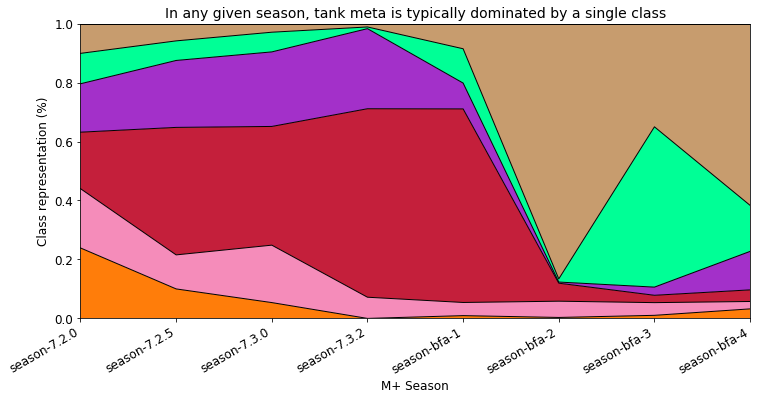

In [458]:
fig = plt.gcf()
fig.set_size_inches(12, 6.5)
plt.rc('font', size=12)
plt.rc('axes', titlesize=14)

plt.stackplot(list(range(len(tank_df_pct_drp))),
              tank_df_pct_drp['Druid'],
              tank_df_pct_drp['Paladin'],
              tank_df_pct_drp['Death Knight'],
              tank_df_pct_drp['Demon Hunter'],
              tank_df_pct_drp['Monk'],
              tank_df_pct_drp['Warrior'],
              colors = ['#FF7D0A', '#F58CBA', '#C41F3B',
                        '#A330C9', '#00FF96', '#C79C6E'])

dfx = np.zeros(8)
for i in ['Druid', 'Paladin', 'Death Knight', 'Demon Hunter', 'Monk', 'Warrior']:
    dfx = dfx + tank_df_pct_drp[i].to_numpy()
    plt.plot(list(range(len(tank_df_pct_drp))),
             dfx, color='black', lw=1)

plt.xticks(list(range(len(tank_df_pct_drp))),list(tank_df_pct_drp.index), rotation=30,
           horizontalalignment='right')

plt.title('In any given season, tank meta is typically dominated by a single class')
plt.ylabel('Class representation (%)')
plt.xlabel('M+ Season')
plt.xlim([0,len(tank_df_pct_drp)-1])
plt.ylim([0,1])

plt.gcf().subplots_adjust(bottom=0.25)

plt.savefig("sample_10_x_7_adj_bot_colors.jpg", dpi=300)


#'(based on top-100 runs from each NA, EU, TW, and KR)'



In [455]:
d = np.zeros(8)
a = tank_df_pct_drp['Druid'].to_numpy()
b = tank_df_pct_drp['Paladin'].to_numpy()

print(a)
print(b)
print(a+b)
print(d+b)

[0.23900524 0.10006306 0.05371401 0.         0.00948767 0.00327771
 0.01046154 0.03236753]
[0.20104712 0.11540887 0.19477377 0.07190635 0.04459203 0.05512515
 0.04307692 0.02505873]
[0.44005236 0.21547194 0.24848778 0.07190635 0.0540797  0.05840286
 0.05353846 0.05742626]
[0.20104712 0.11540887 0.19477377 0.07190635 0.04459203 0.05512515
 0.04307692 0.02505873]


In [422]:
list(range(11))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [212]:
list(range(6))

[0, 1, 2, 3, 4, 5]

In [490]:
tank_df_pct.sum()/tank_df_pct.to_numpy().sum()

tank0_class
Death Knight    0.343351
Demon Hunter    0.150231
Druid           0.051225
Monk            0.126268
Paladin         0.099416
Warrior         0.229509
dtype: float64

### Same analysis, healers

In [466]:
healer_df = legion_df.groupby(['season', 'healer0_class']).size().unstack()

In [467]:
healer_df.drop(['Death Knight', 'Rogue'], axis=1, inplace=True)

In [471]:
healer_df.drop(['season-bfa-3-post',
                'season-post-legion',
                'season-pre-bfa'], inplace=True)

In [480]:
healer_df

healer0_class,Druid,Monk,Paladin,Priest,Shaman
season,,,,,
season-7.2.0,1711.0,49.0,1020.0,568.0,469.0
season-7.2.5,1674.0,106.0,1567.0,808.0,605.0
season-7.3.0,1465.0,33.0,1852.0,560.0,223.0
season-7.3.2,1141.0,11.0,2852.0,144.0,38.0
season-bfa-1,1294.0,740.0,216.0,899.0,13.0
season-bfa-2,2975.0,68.0,212.0,86.0,15.0
season-bfa-3,2693.0,25.0,446.0,73.0,13.0
season-bfa-4,2371.0,213.0,1031.0,160.0,56.0


In [481]:
hlr = healer_df.div(healer_df.sum(axis=1), axis=0)

In [482]:
hlr

healer0_class,Druid,Monk,Paladin,Priest,Shaman
season,,,,,
season-7.2.0,0.448258,0.012837,0.267226,0.148808,0.122871
season-7.2.5,0.351681,0.022269,0.329202,0.169748,0.127101
season-7.3.0,0.354464,0.007985,0.448101,0.135495,0.053956
season-7.3.2,0.272575,0.002628,0.681319,0.034400,0.009078
season-bfa-1,0.409235,0.234029,0.068311,0.284314,0.004111
season-bfa-2,0.886472,0.020262,0.063170,0.025626,0.004470
season-bfa-3,0.828615,0.007692,0.137231,0.022462,0.004000
season-bfa-4,0.618898,0.055599,0.269120,0.041765,0.014618


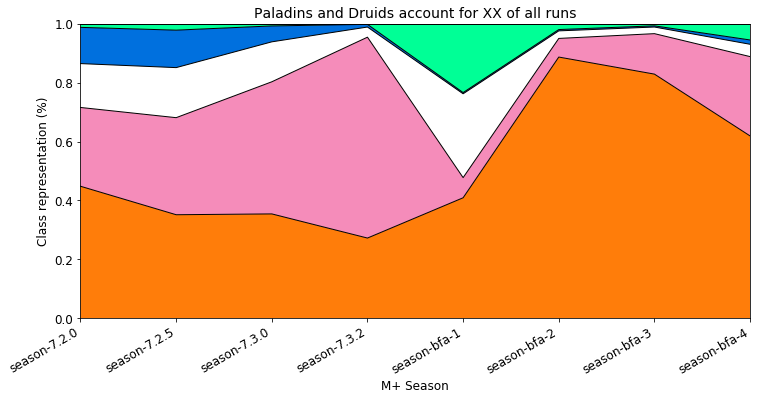

In [492]:
fig = plt.gcf()
fig.set_size_inches(12, 6.5)
plt.rc('font', size=12)
plt.rc('axes', titlesize=14)

plt.stackplot(list(range(len(hlr))),
              hlr['Druid'],
              hlr['Paladin'],
              hlr['Priest'],
              hlr['Shaman'],
              hlr['Monk'],
              colors = ['#FF7D0A', '#F58CBA', '#FFFFFF',
                        '#0070DE', '#00FF96'])

dfx = np.zeros(8)
for i in ['Druid', 'Paladin', 'Priest', 'Shaman', 'Monk']:
    dfx = dfx + hlr[i].to_numpy()
    plt.plot(list(range(len(hlr))),
             dfx, color='black', lw=1)

plt.xticks(list(range(len(hlr))),list(hlr.index), rotation=30,
           horizontalalignment='right')

plt.title('Paladins and Druids account for XX of all runs')
plt.ylabel('Class representation (%)')
plt.xlabel('M+ Season')
plt.xlim([0,len(hlr)-1])
plt.ylim([0,1])

plt.gcf().subplots_adjust(bottom=0.25)

plt.savefig("healers.jpg", dpi=300)

In [487]:
hlr.sum()/hlr.to_numpy().sum()

healer0_class
Druid      0.521275
Monk       0.045413
Paladin    0.282960
Priest     0.107827
Shaman     0.042526
dtype: float64

### Same analysis DPS

In [ ]:
legion_df

### Cumulative table